## Project: Emotion Sentiment Analysis and Prediction Model
### Author:
[Ahmed Abdullah](https://github.com/ahmedembeddedx/)

### 1. *Importing Neccessary Libraries*

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import string
from wordcloud import WordCloud
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.stats import chi2_contingency
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

### 2. *Importing Data from [Kaggle](https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp)*

In [35]:
data = pd.read_csv("data_.csv")

### 3. *Basic Data Preprocessing*

In [4]:
data = data.dropna()
data = data.drop_duplicates()
data = data.reset_index(drop=True)


data.head()

,Text,Emotion
0,i felt anger when at the end of a telephone call,anger
1,i jest i feel grumpy tired and pre menstrual w...,anger
2,i feel just bcoz a fight we get mad to each ot...,anger
3,i am feeling outraged it shows everywhere,anger
4,i highly recommend visiting on a wednesday if ...,anger


### 4. *Initial Data Attributes*

In [39]:
data.info()
data.describe(include="all")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5861 entries, 0 to 5860
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     5861 non-null   object
 1   Emotion  5861 non-null   object
dtypes: object(2)
memory usage: 91.7+ KB


,Text,Emotion
count,5861,5861
unique,5855,6
top,im still not sure why reilly feels the need to...,sadness
freq,2,1052


### 5. *Data Distributions & Unique Emotions*

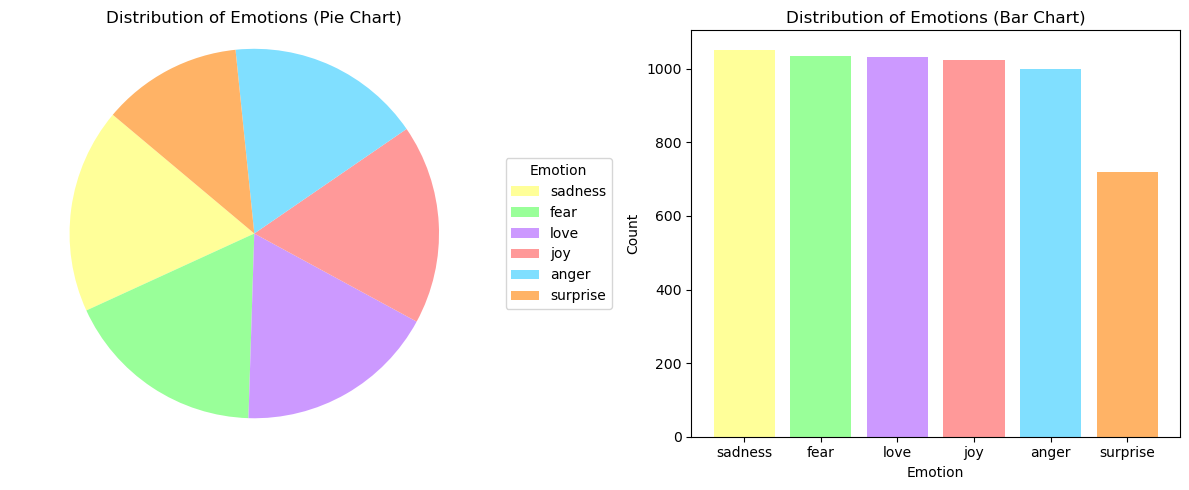

In [7]:
counts = data['Emotion'].value_counts()
colors = ["#FFFF99", "#99FF99", "#CC99FF", "#FF9999", "#80DFFF", "#FFB366"]

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.pie(counts, startangle=140, colors=colors)
plt.legend(counts.index, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))
plt.axis('equal')
plt.title('Distribution of Emotions (Pie Chart)')

plt.subplot(1, 2, 2)
emotion_counts = data['Emotion'].value_counts()
plt.bar(emotion_counts.index, emotion_counts.values, color=colors)
plt.title('Distribution of Emotions (Bar Chart)')
plt.xlabel('Emotion')
plt.ylabel('Count')

plt.tight_layout()

plt.show()


In [59]:
data['Emotion'].value_counts()

sadness     1052
fear        1035
love        1031
joy         1025
anger        999
surprise     719
Name: Emotion, dtype: int64

### 6. *Data Bivariate Analysis with Length*

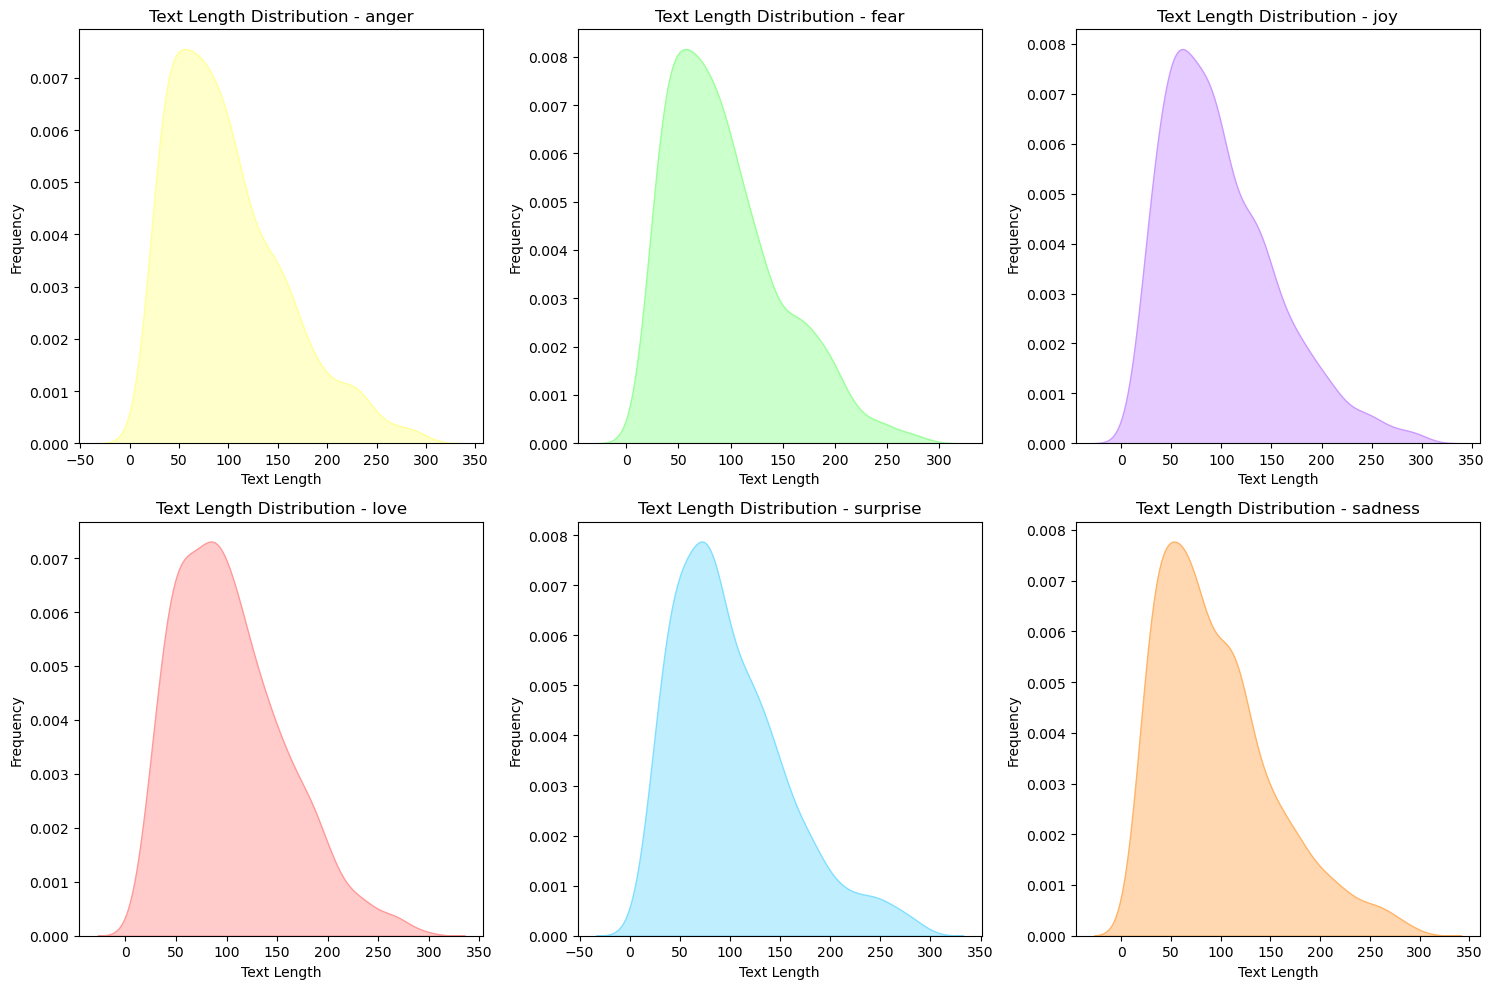

In [62]:
data['Text_Length'] = data['Text'].apply(len)
emotions = data['Emotion'].unique()

plt.figure(figsize=(15, 10))

for i, emotion in enumerate(emotions, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data[data['Emotion'] == emotion]['Text_Length'], label=emotion, fill=True, alpha=0.5, color=colors[i-1])
    plt.title(f'Text Length Distribution - {emotion}')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')

plt.tight_layout()    
plt.show()

data = data.drop('Text_Length', axis=1)


### 7. *NLP Preprocessing for readibility*

In [63]:
def data_preprocessing(text):
    t=""
    for achar in text:
        if achar not in string.punctuation:
                t+=achar
    text=t            
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in string.punctuation]

    stopword_list = set(stopwords.words("english"))
    avoid_these = ['very', 'too', 'never']
    remove_these = ['and', 'feel','im', 'my', 'like', 'get']

    result = []
    for token in tokens:
        if token not in remove_these and token not in stopword_list:
            result.append(token)
        elif token in avoid_these:
            result.append(token)

    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(token, pos='v') for token in result]
    
    tokens.clear()
    
    for token in result:
        if token not in remove_these and token not in stopword_list:
            tokens.append(token)
        elif token in avoid_these:
            tokens.append(token)

    return ' '.join(tokens)

In [64]:
data['Text'] = data['Text'].apply(data_preprocessing)

In [65]:
data.head()

,Text,Emotion
0,felt anger end telephone call,anger
1,jest grumpy tire pre menstrual probably week f...,anger
2,bcoz fight mad n u wan na make publicity n let...,anger
3,outrage show everywhere,anger
4,highly recommend visit wednesday youre able le...,anger


In [66]:
memory_usage = data.memory_usage(deep=True).sum()

print(f"Memory usage of the DataFrame: {memory_usage / (1024**2):.2f} MB")

Memory usage of the DataFrame: 0.96 MB


### 8. *Data Word Clouds*

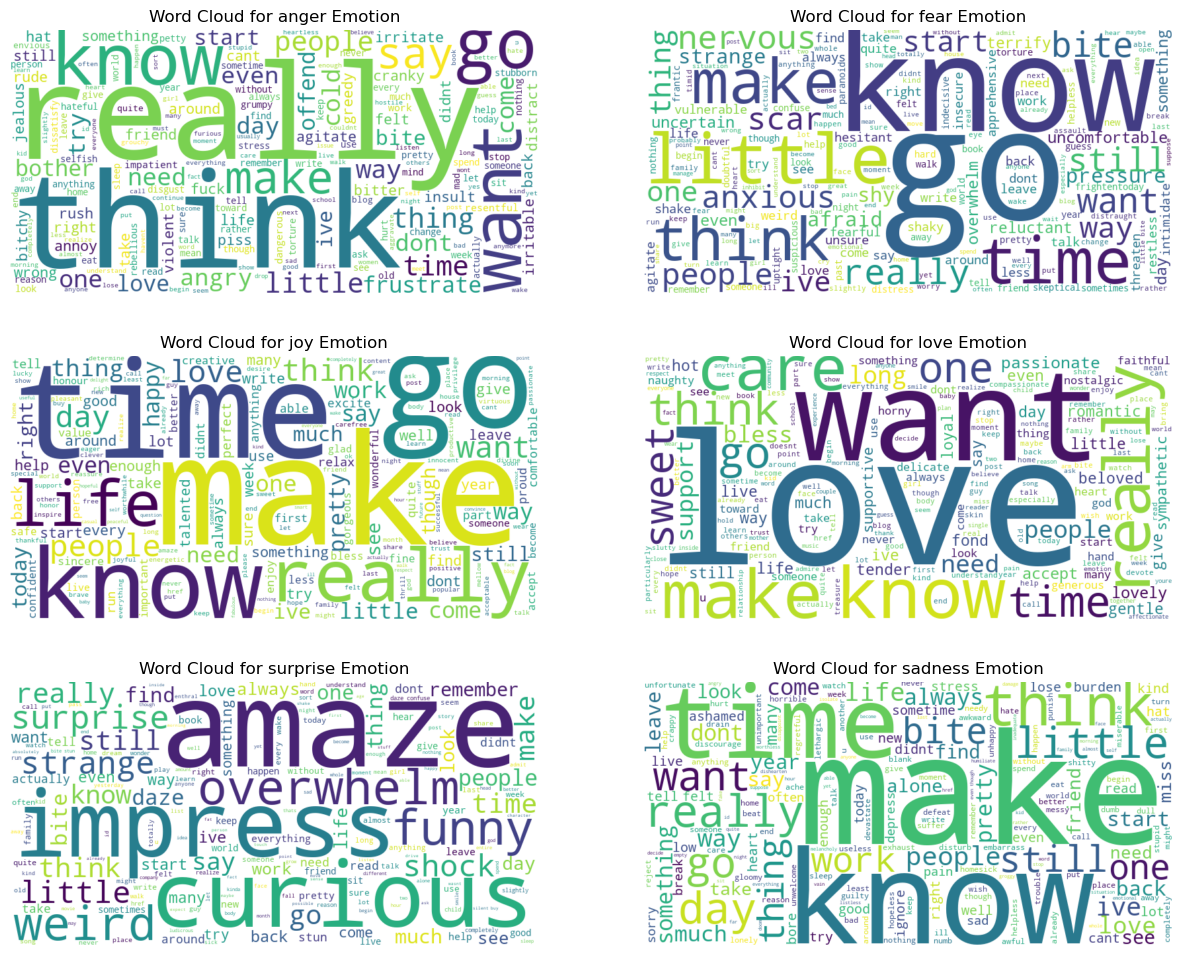

In [67]:
emotions = data['Emotion'].unique()

plt.figure(figsize=(15, 12))
i=1
for emotion in emotions:
    text_for_emotion = ' '.join(data[data['Emotion'] == emotion]['Text'])
    
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_emotion)
    
    plt.subplot(3, 2, i)
    i+=1
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {emotion} Emotion')
    plt.axis('off')
plt.show()


### 9. *Text Vectorization, Train-Test Split & Model Training*

In [71]:
X=data['Text']
Y=data['Emotion']

X_Train, X_Test, Y_Train, Y_Test= train_test_split(X, Y, test_size=0.1, random_state=42)

tf_vector = TfidfVectorizer(max_features=10000)
tf_vector_XTrain = tf_vector.fit_transform(X_Train)
tf_vector_XTest = tf_vector.transform(X_Test)

In [72]:
n_estimators = 200
classifier = RandomForestClassifier(n_estimators=n_estimators, verbose=0)

with tqdm(total=n_estimators, desc="Training") as pbar:
    classifier.fit(tf_vector_XTrain, Y_Train)
    pbar.update(n_estimators)

Y_Pred = classifier.predict(tf_vector_XTest)
accuracy = accuracy_score(Y_Pred, Y_Test) * 100
print("Accuracy: {:.2f}%".format(accuracy))


Training: 100%|██████████████████████████████████████████████████████████████████████| 200/200 [00:35<00:00,  5.66it/s]

Accuracy: 86.71%


### 10. *Model Evaluation & Report*

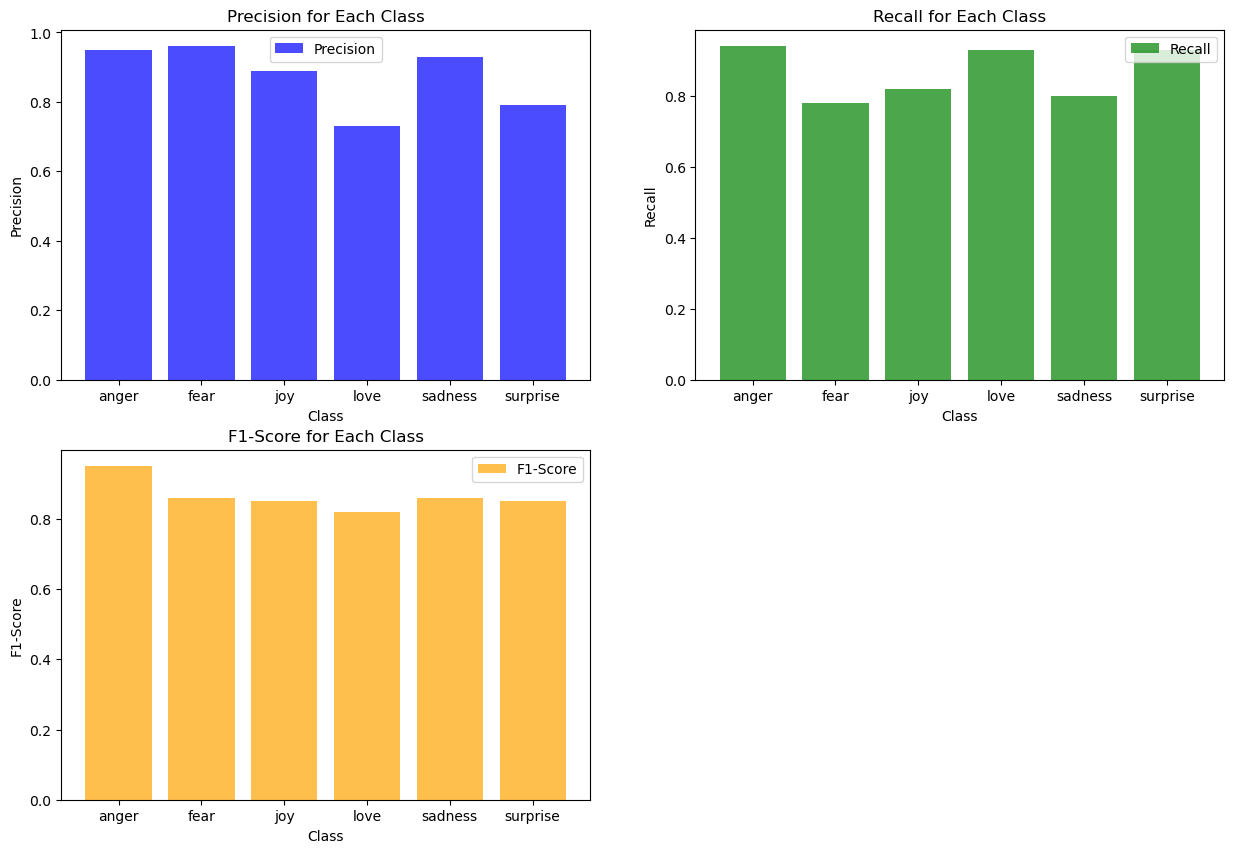

In [73]:
report = classification_report(Y_Test, Y_Pred)
report_lines = report.split('\n')[2:-5]
classes = []
precision = []
recall = []
f1_score = []

for line in report_lines:
    values = line.split()
    if values:
        classes.append(values[0])
        precision.append(float(values[1]))
        recall.append(float(values[2]))
        f1_score.append(float(values[3]))


plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.bar(classes, precision, color='blue', alpha=0.7, label='Precision')
plt.title('Precision for Each Class')
plt.xlabel('Class')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 2)
plt.bar(classes, recall, color='green', alpha=0.7, label='Recall')
plt.title('Recall for Each Class')
plt.xlabel('Class')
plt.ylabel('Recall')
plt.legend()

plt.subplot(2, 2, 3)
plt.bar(classes, f1_score, color='orange', alpha=0.7, label='F1-Score')
plt.title('F1-Score for Each Class')
plt.xlabel('Class')
plt.ylabel('F1-Score')
plt.legend()
plt.show()


### 11. *Confusion Matrix*

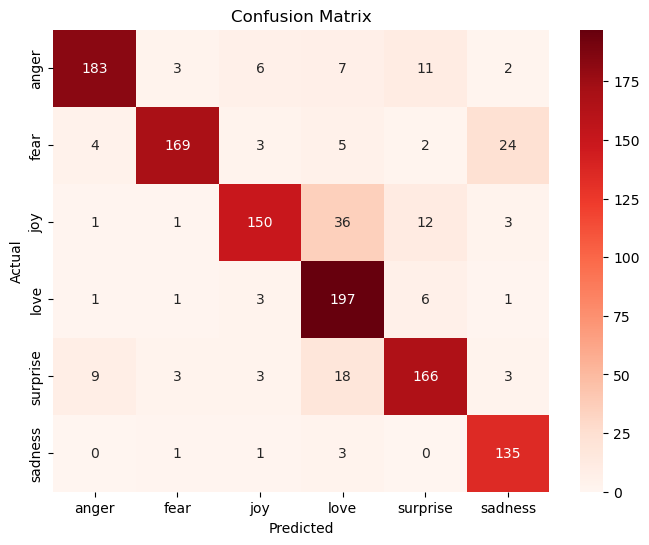

In [23]:
emotes = data['Emotion'].unique()
conf_matrix=confusion_matrix(Y_Test, Y_Pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=emotes, yticklabels=emotes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### 12. *Model Testing through Human Data*

1 .  I love flying in the air in the winds of Lahore
2 .  I'm really mad that you broke my trust like that!
3 .  Getting unexpected good news made me incredibly happy.
4 .  i feel a little saddened, cant imagine what the folks who were working in the studio
5 .  i just do not feel uptight at all
6 .  i have a feeling that even if this was the only line up there jesse might make the hike all over again just to finish this amazing project


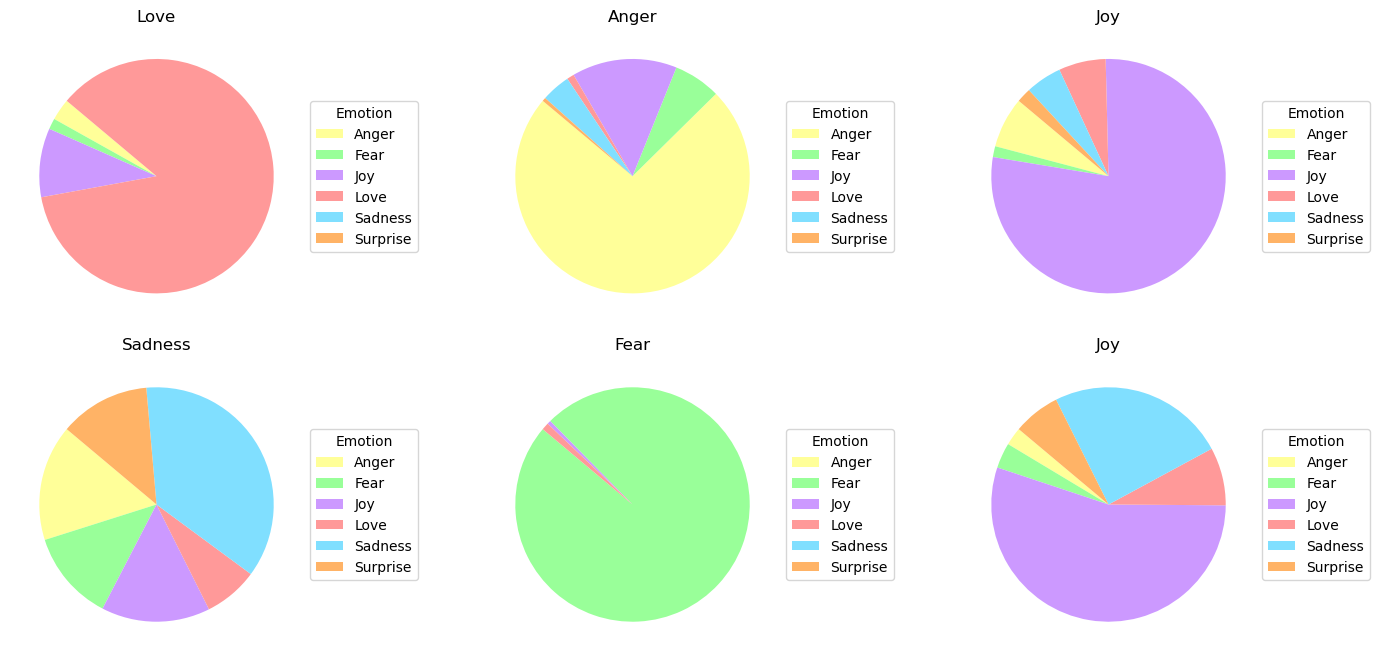

In [74]:
texts = ["I love flying in the air in the winds of Lahore",
        "I'm really mad that you broke my trust like that!",
        "Getting unexpected good news made me incredibly happy.",
        "i feel a little saddened, cant imagine what the folks who were working in the studio",
        "i just do not feel uptight at all",
        "i have a feeling that even if this was the only line up there jesse might make the hike all over again just to finish this amazing project"
        ]


plt.figure(figsize=(15, 10))
i = 1

for text in texts:
    new_text_tfidf = tf_vector.transform([text])
    predicted_probabilities = classifier.predict_proba(new_text_tfidf)
    print(i, ". ", text)

    labels = ['Anger', 'Fear', 'Joy', 'Love', 'Sadness', 'Surprise']
    plt.subplot(3, 3, i)
    i += 1
    plt.pie(predicted_probabilities[0], startangle=140, colors=colors)
    plt.legend(labels, title='Emotion', loc='center left', bbox_to_anchor=(1, 0.5))
    title = classifier.predict(new_text_tfidf)
    plt.title(str(title)[2:-2].capitalize())

plt.tight_layout()
plt.show()
